In [20]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from rad_utils import remove_all_ticks_and_labels
from tqdm.auto import tqdm, trange
import os
import json

# also need scipy and scikit-learn

# import dataset

returning as tensor


[Text(0.5, 1.0, 'Ground Truth Manifold')]

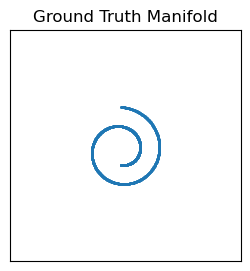

In [21]:
# import dataset
from generate_data import load_unimodal_data, load_unimodal_data_3d, load_unimodal_data_nd, make_nd_dataset
from rad_utils import generate_2d_swiss_roll

gt_manifold_t, gt_manifold, _, _ = generate_2d_swiss_roll(1e3, return_as_tensor=True)
# gt_manifold = load_unimodal_data(1e4, manifold_type='line', plot=False)

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.scatter(*gt_manifold.T, s=1)
ax.set_aspect('equal')
lims=[-3, 3]
ax.set(xlim=lims, ylim=lims)
remove_all_ticks_and_labels(ax)
ax.set(title='Ground Truth Manifold')

# training process

In [22]:
# training process
from utils import forward_process, noise_estimation_loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def reverse_process(model, 
                    model_name, 
                    model_number, 
                    num_steps, 
                    num_hidden, 
                    num_dims,
                    num_epochs,
                    batch_size,
                    lr,
                    device,
                    dataset,
                    pretrained_model):
    
    # beta-related parameters
    coefs = forward_process(num_steps, device)
    betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
    alphas_bar_sqrt = alphas_bar_sqrt.to(device)
    one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)
    
    # training set
    dataset = dataset.to(device)
    
    # define model
    if pretrained_model['use_pretrained_model_weights']:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    model.to(device)

    # training parameteres
    optimizer = optim.Adam(model.parameters(), lr=lr)

    tb = SummaryWriter(f'runs/{model_name}_{model_number}')
    start_time = time.time()
    
    # start training
    model.train()
    for t in trange(int(num_epochs), desc='Training model', unit='epochs'):
        permutation = torch.randperm(dataset.size()[0], device=device)
    
        for i in range(0, dataset.size()[0], batch_size):
            # retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices]
            
            # compute the loss
            loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
        
        # write to tensorboard
        tb.add_scalar('Loss', loss.item(), t)

        # print loss
        if (t % (num_epochs/10) == 0):
            print('t', t)
            print('loss', loss.item())
    tb.flush()

    end_time = time.time()
    duration = end_time - start_time
    duration_mins = duration / 60
    print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')
    return model

# run

In [28]:
# define hyperparameter values
global device
device = torch.device('cpu')
print(device)


# -------------------------- set model parameters -------------------------- #
# model_name = 'single_layer_network'
model_name = 'unconditional-dendritic'
model_number = 51
num_steps = 100
num_hidden = [3, 3, 3, 3, 3, 3, 4]
num_ambient_dims = 2
num_samples_in_training_set = 1e3
epochs = 1e4
manifold_type = 'swiss_roll'
batch_size = 128
lr = 1e-4
pretrained_model = {
    'use_pretrained_model_weights': True,
    'model_name': 'unconditional-dendritic',
    'model_num': 50
}


# -------------------------- save model description -------------------------- #
description = {
    'model_name': model_name,
    'model_number': model_number,
    'num_steps': num_steps,
    'num_hidden': num_hidden,
    'num_ambient_dims': num_ambient_dims,
    'num_samples_in_training_set': f'{num_samples_in_training_set:.0e}',
    'num_epochs': f'{epochs:.0e}',
    'manifold_type': manifold_type,
    'batch_size': batch_size,
    'learning_rate': f'{lr:.0e}',
    'use_pretrained_model': pretrained_model['use_pretrained_model_weights'],
}
if pretrained_model['use_pretrained_model_weights']:
    description['pretrained_model_name'] = pretrained_model['model_name']
    description['pretrained_model_num'] = pretrained_model['model_num']

json_savedir = 'model_description'
model_name_and_number = f'{model_name}_{model_number}'
json_name = f'{model_name_and_number}.json'
with open(os.path.join(json_savedir, json_name), 'w') as file:
    json.dump(description, file)




# model = SingleLayerNetwork(num_hidden)
# model = SNN2(num_hidden)
# model = SNN3(num_hidden)

# from models import NoiseConditionalEstimatorConcat
# model = NoiseConditionalEstimatorConcat(num_hidden)

from models import VariableDendriticCircuit
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)


_, dataset, _, _ = generate_2d_swiss_roll(int(num_samples_in_training_set), return_as_tensor=True)
# dataset = load_unimodal_data(int(num_samples_in_training_set), manifold_type='line', plot=False)

# -------------------- TRAINING - reverse diffusion process ------------------ #
model = reverse_process(model, model_name, model_number, num_steps, num_hidden, num_ambient_dims, epochs, batch_size, lr, device, dataset, pretrained_model)
from utils import save_model_weights
save_model_weights(model, model_name, model_number)

cpu
returning as tensor
taking weights from pretrained model unconditional-dendritic_50!
model loaded!


Training model:   0%|          | 0/10000 [00:00<?, ?epochs/s]

t 0
loss 0.6393285393714905
t 1000
loss 0.9455594420433044
t 2000
loss 0.8456169962882996
t 3000
loss 0.7699394226074219
t 4000
loss 0.8748996257781982
t 5000
loss 0.847597062587738
t 6000
loss 0.7617307305335999
t 7000
loss 0.7187122106552124
t 8000
loss 0.7620842456817627
t 9000
loss 0.8466437458992004
training took 659 seconds, which is 10.98 minutes.
model state dict saved in directory: ./saved_weights/


# testing

model loaded!


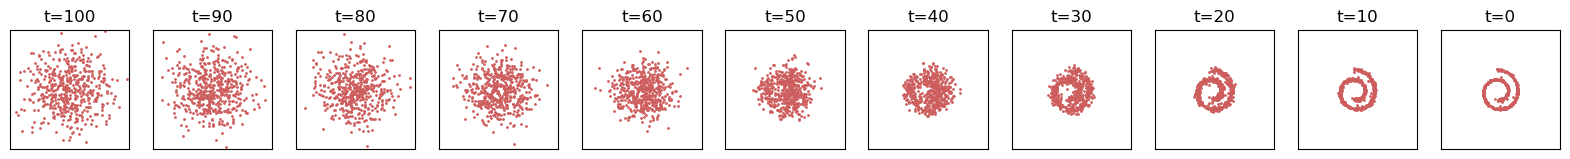

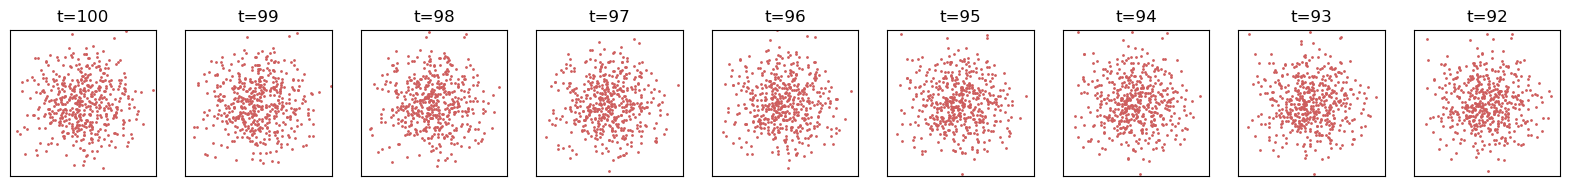

In [31]:
from generate_data import p_sample_loop, p_sample_loop_new, p_sample_loop_snn
from utils import forward_process, load_model_weights
from models import NoiseConditionalEstimatorConcat

sample_size = 5e2
lims = [-3,3]

num_hidden = 42

# model = SingleLayerNetwork(num_hidden)
# model = load_model_weights(model, 'single_layer_network', 10, device)

# model = SNN3(num_hidden)
# model = load_model_weights(model, 'snn3', 2, device)

num_hidden = [3, 3, 3, 3, 3, 3, 4]
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
model = load_model_weights(model, 'unconditional-dendritic', 47, device)

# model = NoiseConditionalEstimatorConcat(num_hidden)
# model = load_model_weights(model, 'unconditional-concat', 16, device)

x_seq = p_sample_loop_new(model, (int(sample_size), num_ambient_dims), num_steps, device)  # with sampling noise
# x_seq = p_sample_loop_snn(model, (int(sample_size), num_ambient_dims), num_steps, device)  # withouth sampling noise

fig, axes = plt.subplots(1, 11, figsize=(20, 3), sharey=True)
for i in range(0, 11):
    cur_x = x_seq[i * 10].detach().cpu()
    ax = axes[i]
    ax.scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='indianred', s=1);
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-i*10}')
    
fig, axes = plt.subplots(1, 9, figsize=(20, 3), sharey=True)
i = 0
for ax in axes:
    ax.scatter(x_seq[i][:, 0], x_seq[i][:, 1],color='white',edgecolor='indianred', s=1)
    ax.set_aspect('equal')
    ax.set(xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax)
    ax.set(title=f't={100-i}')
    i += 1